# Выбор локации для скважины

Некая нефтедобывающая компания предоставила нам пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Необходимо построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Описание 

Нам необходимо принять решение о выборе места для бурения новой скважины.

Нам предоставлены пробы нефти в трёх разных регионах. Характеристики для каждой скважины в регионе уже известны. Необходимо построить модель для определения региона, где добыча принесёт наибольшую прибыль. 

Проанализируем возможную прибыль и риски техникой Bootstrap.

Для этого, сначала нужно будет изучить данные, очистить их от выбросов

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings('ignore')

## Загрузка и подготовка данных

In [2]:
df_0 = pd.read_csv('/datasets/geo_data_0.csv', delimiter=',', decimal='.')
df_1 = pd.read_csv('/datasets/geo_data_1.csv', delimiter=',', decimal='.')
df_2 = pd.read_csv('/datasets/geo_data_2.csv', delimiter=',', decimal='.')

In [3]:
df_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
df_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
df_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [6]:
def df_info(data):
    return (data.info(), data.describe(), f'Количество дубликатов: {sum(data.duplicated())}')

In [7]:
df_info(df_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        0.500419       0.250143       2.502647      92.500000
 std         0.871832       0.504433       3.248248      44.288691
 min        -1.408605      -0.848218     -12.088328       0.000000
 25%        -0.072580      -0.200881       0.287748      56.497507
 50%         0.502360       0.250252       2.515969      91.849972
 75%         1.073581       0.700646       4.715088     128.564089
 max         2.362331       1.343769      16.003790     185.364347,
 'Количество дубликатов: 0')

In [8]:
df_info(df_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        1.141296      -4.796579       2.494541      68.825000
 std         8.965932       5.119872       1.703572      45.944423
 min       -31.609576     -26.358598      -0.018144       0.000000
 25%        -6.298551      -8.267985       1.000021      26.953261
 50%         1.153055      -4.813172       2.011479      57.085625
 75%         8.621015      -1.332816       3.999904     107.813044
 max        29.421755      18.734063       5.019721     137.945408,
 'Количество дубликатов: 0')

In [9]:
df_info(df_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(None,
                   f0             f1             f2        product
 count  100000.000000  100000.000000  100000.000000  100000.000000
 mean        0.002023      -0.002081       2.495128      95.000000
 std         1.732045       1.730417       3.473445      44.749921
 min        -8.760004      -7.084020     -11.970335       0.000000
 25%        -1.162288      -1.174820       0.130359      59.450441
 50%         0.009424      -0.009482       2.484236      94.925613
 75%         1.158535       1.163678       4.858794     130.595027
 max         7.238262       7.844801      16.739402     190.029838,
 'Количество дубликатов: 0')

Данные соответствуют описанию, дубликаты и пропуски не выявлены.
Типы данных соответствуют предоставленному описанию.

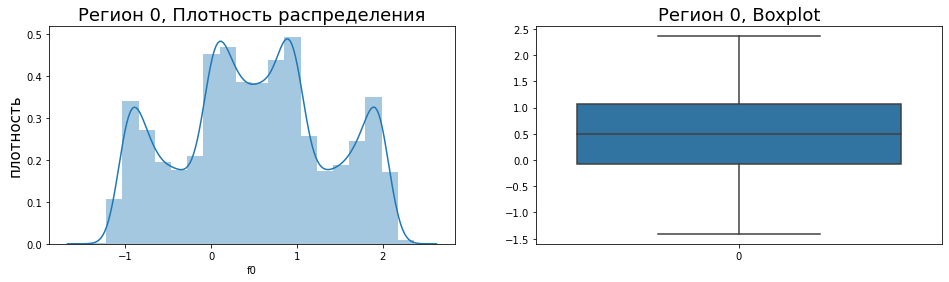

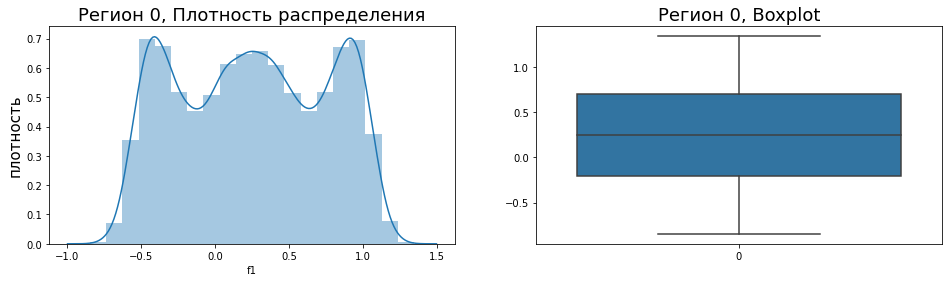

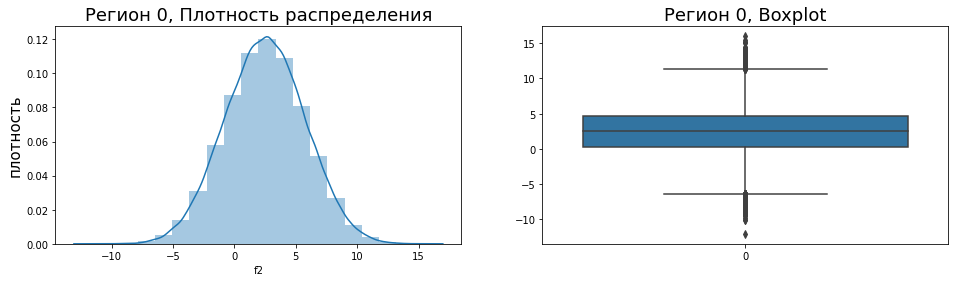

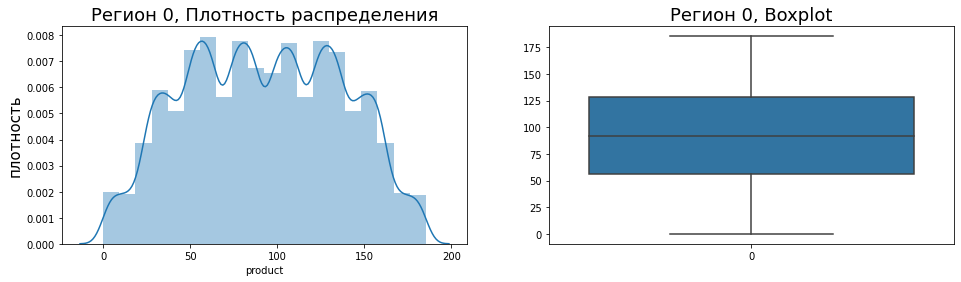

In [46]:
def plot_func(data, name, num_bins, rug=False):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(name + ", Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(name + ", Boxplot", fontsize=18)
    sns.boxplot(data=data, ax=axes[1])
    plt.show()
    
def reg_plot_func(data, name):
    numerics = ['f0', 'f1', 'f2', 'product']
    for column in numerics:
        plot_func(data[column], name=name, num_bins=20)   
        
reg_plot_func(df_0, name='Регион 0')

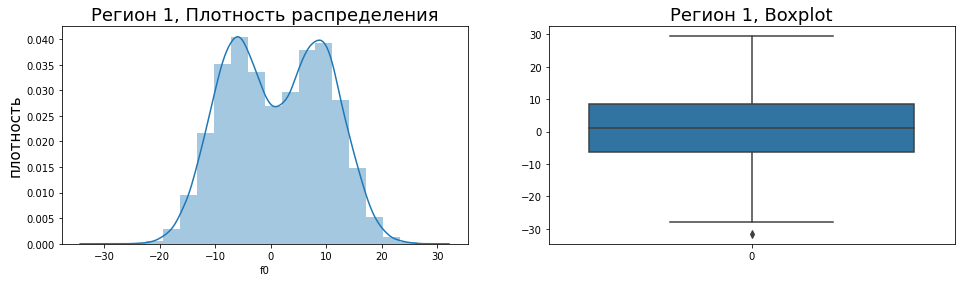

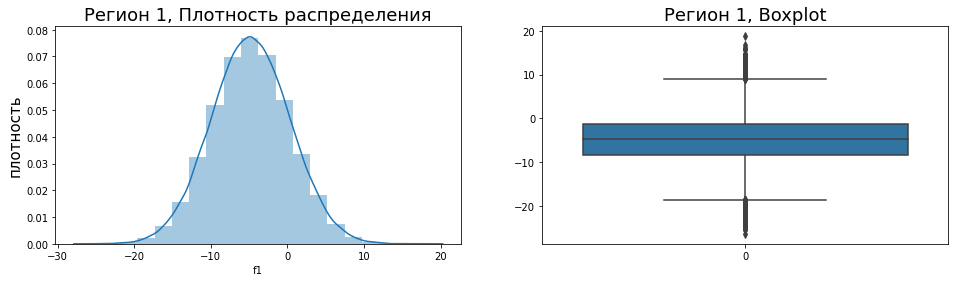

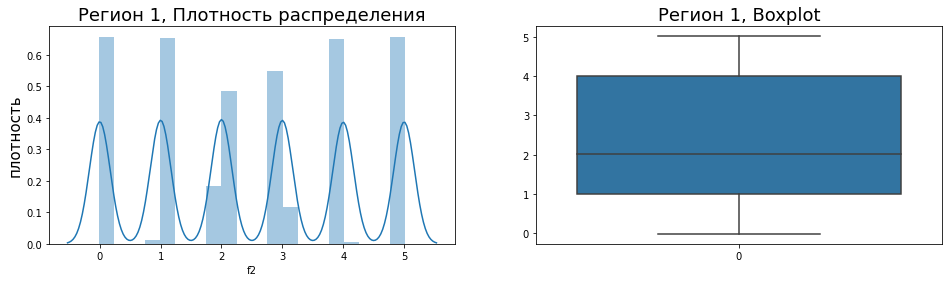

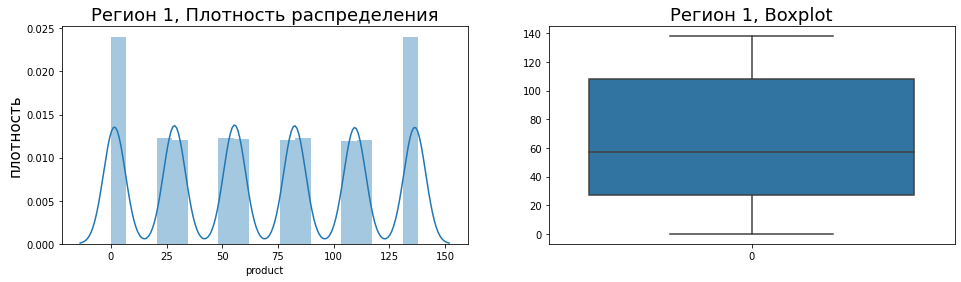

In [47]:
reg_plot_func(df_1, name='Регион 1')

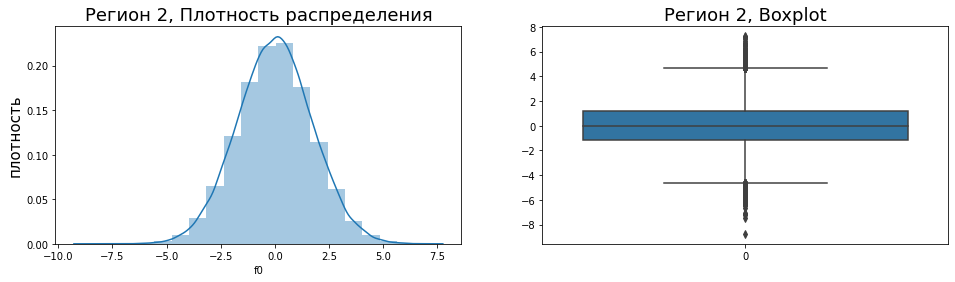

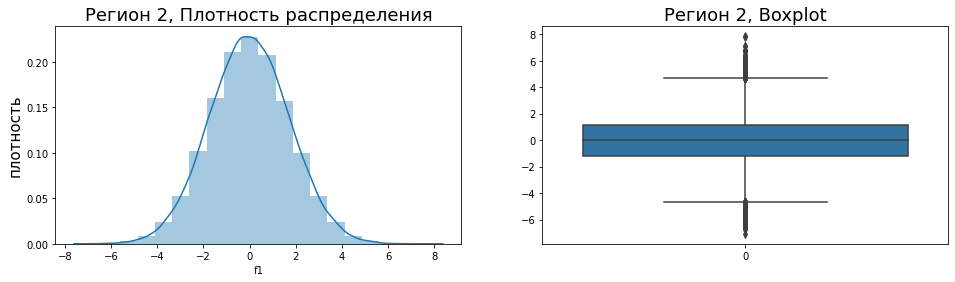

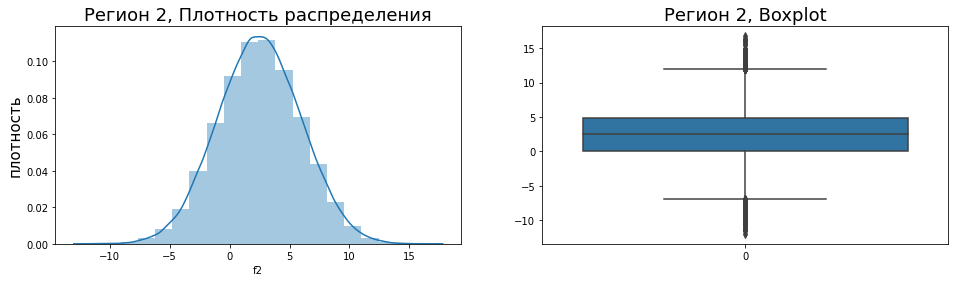

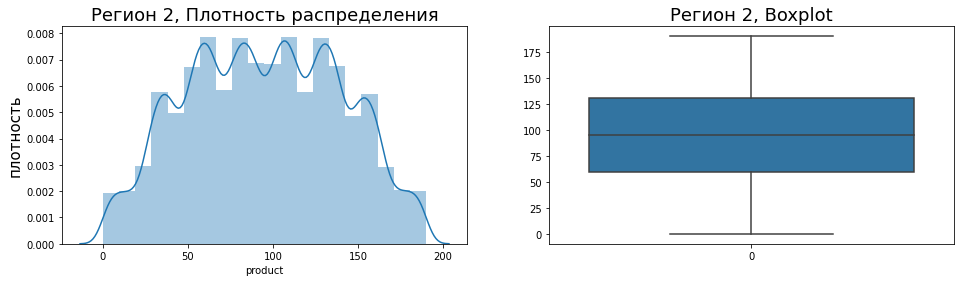

In [48]:
reg_plot_func(df_2, name='Регион 2')

Распределения некоторых признаков отличаются от нормального. Наблюдаются небольшие выбросы. 

Масштабы распределений признаков f0, f1, f2 не значительно отличаются друг от друга, поэтому масштибирование в нашем случае не нужно.

## Обучение и проверка модели

In [13]:
data1 = df_0.drop(['id'], axis=1)
data2 = df_1.drop(['id'], axis=1)
data3 = df_2.drop(['id'], axis=1)

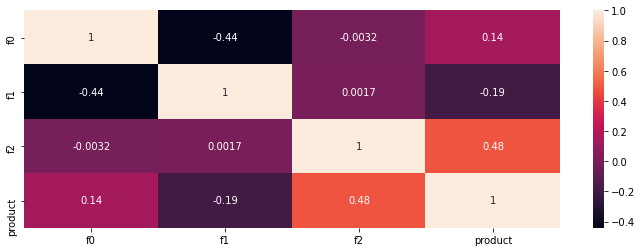

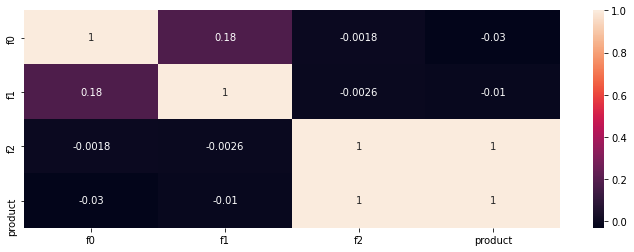

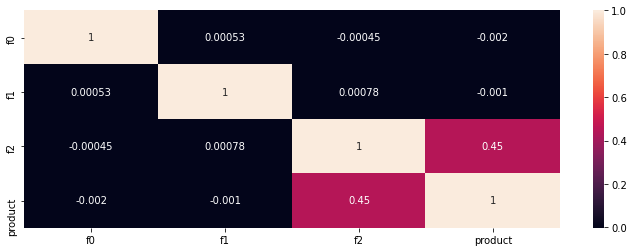

In [14]:
for i in [data1,data2,data3]:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 1, 1) 
    sns.heatmap(i.corr(), annot = True);

In [49]:
features = ['f0', 'f1', 'f2']
target = ['product']
X_0 = df_0[features]
y_0 = df_0[target]
X_1 = df_1[features]
y_1 = df_1[target]
X_2 = df_2[features]
y_2 = df_2[target]

In [50]:
def model_fit(X, y):

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
    print('Train shape:', X_train.shape)
    print('Valid shape:', X_valid.shape)
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    predict = model.predict(X_valid)

    predict_mean = predict.mean()
    rmse = mean_squared_error(y_valid, predict)**.5

    print('Cредний запас предсказанного сырья: {:.4f}'.format(predict_mean))
    print('RMSE модели: {:.4f}'.format(rmse))
    
    return y_valid, predict

In [17]:
y_0_valid, predict_0 = model_fit(X_0, y_0)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 92.3988
RMSE модели: 37.7566


In [18]:
y_1_valid, predict_1 = model_fit(X_1, y_1)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 68.7129
RMSE модели: 0.8903


In [19]:
y_2_valid, predict_2 = model_fit(X_2, y_2)

Train shape: (75000, 3)
Valid shape: (25000, 3)
Cредний запас предсказанного сырья: 94.7710
RMSE модели: 40.1459


В регионе df_2 средний запас сырья выше, чем в остальных. Однако, вероятность ошибки прогноза минимальна в регионе df_1, значит пргноз здесь сработал более точно.

## Подготовка к расчёту прибыли

По условию

- budget = Бюджет на разработку скважин в регионе — 10 млрд рублей
- top_wells = При расчёте выбирают 200 лучших скважин
- samp_wells = Всего скважин в выборке 500
- unit_income =  Доход с каждой единицы продукта составляет 450 тыс. рублей

Из этого следует формула:
min_product = budget / (top_wells * unit_income)

In [20]:
BUDGET = 10**10
TOP_WELLS = 200
SAMP_WELLS = 500
UNIT_INCOME = 4.5*10**5

In [21]:
min_product = BUDGET / (TOP_WELLS * UNIT_INCOME)
print('Минимальный объём с одной скважины для безубыточной разработки: {:.2f}'.format(min_product))

Минимальный объём с одной скважины для безубыточной разработки: 111.11


Минимальный объём для безубыточной разработки составляет 111.11. Полученное значение превышает средние запасов скважин по всем регионам.

## Расчёт прибыли и рисков 

### Расчёт прибыли 

In [22]:
y_0_valid = pd.Series(y_0_valid['product']).reset_index(drop=True)
y_1_valid = pd.Series(y_1_valid['product']).reset_index(drop=True)
y_2_valid = pd.Series(y_2_valid['product']).reset_index(drop=True)

In [23]:
predict_0 = pd.Series(*predict_0.reshape(1,-1))
predict_1 = pd.Series(*predict_1.reshape(1,-1))
predict_2 = pd.Series(*predict_2.reshape(1,-1))

In [24]:
def show_pred_income(region, top_wells_mean, volume, income):
    print(region)
    print('Средний запас сырья среди лучших скважин: {:.2f}'.format(top_wells_mean))
    print('Суммарный целевой объём сырья: {:.2f}'.format(volume))
    print('Прибыль для полученного объёма сырья: {:.2f}'.format(income))

In [25]:
state = 42
def pred_income(target, predicts, region, state, replace=False, show_res=True, return_res=False):

    sample_preds = predicts.sample(n=SAMP_WELLS, 
                                   replace=replace, 
                                   random_state=state)
    top_preds = sample_preds.sort_values(ascending=False)[:TOP_WELLS]
    top_targets = target[top_preds.index]
    top_wells_mean = top_targets.mean()
    volume = sum(top_targets)
    income = volume * UNIT_INCOME - BUDGET
    if show_res:
        show_pred_income(region, top_wells_mean, volume, income)
    if return_res:
        return income

In [26]:
pred_income(y_0_valid, predict_0, 'Регион 0', state)

Регион 0
Средний запас сырья среди лучших скважин: 113.15
Суммарный целевой объём сырья: 22629.14
Прибыль для полученного объёма сырья: 183112236.31


In [27]:
pred_income(y_1_valid, predict_1, 'Регион 1', state)

Регион 1
Средний запас сырья среди лучших скважин: 115.96
Суммарный целевой объём сырья: 23191.83
Прибыль для полученного объёма сырья: 436323404.69


In [28]:
pred_income(y_2_valid, predict_2, 'Регион 2', state)

Регион 2
Средний запас сырья среди лучших скважин: 116.33
Суммарный целевой объём сырья: 23265.40
Прибыль для полученного объёма сырья: 469431517.00


### Расчёт рисков 

Воспользуемся Bootstrap с 1000 выборок, для поиска распределения прибыли.
Расчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [29]:
def risk_func(region, income_mean, conf_int_left, conf_int_right, loss_rate):
    print(region)
    print('Средняя прибыль {:.2f} млн руб.'.format(income_mean / 10**6))
    print('95% доверительный интервал: {:.2f} : {:.2f} млн руб.'.format(conf_int_left / 10**6, conf_int_right / 10**6))
    print('Риск убытков: {:.2f} %'.format(loss_rate * 100))

In [30]:
def risk_calc_func(target, predicts, region):

    bootstrap_samples = 1000
    alpha = 0.05
    incomes = []
    state = np.random.RandomState(42)
    for _ in range(bootstrap_samples):
        income = pred_income(target, predicts, region, state, replace=True, show_res=False, return_res=True)
        incomes.append(income)

    incomes = pd.Series(incomes)
    income_mean = incomes.mean()
    conf_int_left = incomes.quantile(alpha/2)
    conf_int_right = incomes.quantile(1 - alpha/2)
    
    loss_count = 0
    for inc in incomes :
        if inc < 0 :
            loss_count += 1
    loss_rate = loss_count / bootstrap_samples
    
    risk_func(region, income_mean, conf_int_left, conf_int_right, loss_rate)

In [31]:
risk_calc_func(y_0_valid, predict_0, 'Регион 0')

Регион 0
Средняя прибыль 399.58 млн руб.
95% доверительный интервал: -110.47 : 897.46 млн руб.
Риск убытков: 6.00 %


In [32]:
risk_calc_func(y_1_valid, predict_1, 'Регион 1')

Регион 1
Средняя прибыль 452.05 млн руб.
95% доверительный интервал: 61.68 : 845.34 млн руб.
Риск убытков: 1.50 %


In [33]:
risk_calc_func(y_2_valid, predict_2, 'Регион 2')

Регион 2
Средняя прибыль 375.01 млн руб.
95% доверительный интервал: -144.77 : 888.39 млн руб.
Риск убытков: 8.00 %


## Вывод

При начальном построении модели и предсказаний:
- В регионах 0 и 2 достаточно высокий средний показатель запаса предсказанного сырья, но и RMSE для этих регионов  высок (37.8 и 40.1 соответственно). Это показатель далеко не лучшей точности модели.
- В регионе 1 средний показатель запаса предсказанного сырья составляет 68.7, что ниже остальных регионов, но и RMSE в данном регионе значительно ниже - 0.9. Это явный признак неплохой точности предсказаний и качества построенной модели.
- Средние показатели предсказанного сырья для одной скважины ниже теоретически необходимых (111.11)


При расчёте показателей для 200 наилучших скважин из выборочных 500 - средний запас сырья с одной скважины среди всех регионов превосходит минимально необходимый объём.

После применении техники bootstrap, средняя прибыль максимальна для региона 1 (452.05 млн.).
Только регион 1 прогнозирует прибыльную разработку по 95% доверительному интервалу, риск убытков для данного региона (1.5%)

По итогу исследования, можем рекоменовать регион 1 для разработки.